<h1 style="text-align:center;font-size:30px;" > Twitter Sentiment Extraction </h1>

<h1> 1. Business Problem </h1>

With thousands of tweets circulating per second in the Twitter(a social  media platform where people share their opinions in text format  mostly), it is really hard to tell whether the sentiment behind the  specific tweet will impact the whole world related to that tweet.  Capturing sentiment in these times is very important because it  changes the whole dimensions and decisions that are to be made. But  what words actually leads to the sentiment description? If we  somehow find those words,then when a tweet is about to be  tweeted,we can check for these words and remove these words as  per our required sentiment.

This problem is about constructing a model that will look at the labeled sentiment for a given tweet and figure out what word or phrase best supports it.

> Credits: Kaggle 




__ Problem Statement __

-> we will be extracting the phrase from an given tweet that reflect the sentiment given for that sentence(tweet).

-> By correctly extracting the words/phrases we can know which words are contributing to a particular sentiment of the tweet and how that tweet will be portrayed in the real world.

<h2> Real world/Business Objectives and Constraints </h2>

Objectives:

 

*   Predict the phrase from  given sentence as per its given sentiment.

*   Correctly predict the words as far as possible.




<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

-> Get the data from : https://www.kaggle.com/c/tweet-sentiment-extraction/data

-> Data has two files: train.csv and test.csv

-> train.csv contains 4 columns: 3 input features and a target feature


<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

Here input and output both are text data and output text is a part of input text,so we have to try different approach here.We will later see how we can model this problem as multi label classification problem,question and answer system and try some other approaches.

<h3> 2.2.2 Performance Metric </h3>


 Jaccard similarity for strings -> word level Jaccard score.

<h3> 2.2.3 Machine Learning Objective and Constraints </h3>

Maxmimise the jaccard score so that predicted phrases matches the actual phrases

### Loading train and test data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import datetime
import gc
from tqdm import tqdm

import pandas as pd
import numpy as np
from numpy import median

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.manifold import TSNE
from sklearn import preprocessing

from collections import Counter

import string
import re
from nltk.corpus import stopwords

import scipy
from scipy import hstack

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.linear_model import Ridge

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss

from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.feature_selection.univariate_selection import SelectKBest, f_regression

In [ ]:
train = pd.read_csv('train.csv')
print("shape of train data:",train.shape)
train.head()

shape of train data: (27481, 4)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
train.info() #details of train data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


**Observation:** We can see that there are 3 columns that are useful to us:

text:given text of the tweet

selected_text: a part of the text column

sentiment : sentiment of the tweet 

we can observe that there is one null value in text and selected_text columns 



In [ ]:
test = pd.read_csv('test.csv')
print("shape of test data:",test.shape)
test.head()

shape of test data: (3534, 3)


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [ ]:
test.info() #details of test data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


**Observation:** Except selected text column which we have to predict,all the columns remain same as that of train data and there are no null values in the data.

## Data Overview

###Checking for duplicate rows

In [ ]:
train[train.duplicated()]

,textID,text,selected_text,sentiment


**observation:** empty dataframe indicates that there are no duplicate rows

#### Checking for missing values

In [ ]:
train.isnull().any() #for train data

textID           False
text              True
selected_text     True
sentiment        False
dtype: bool

In [ ]:
test.isnull().any() #for test data

textID       False
text         False
sentiment    False
dtype: bool

From info of train data,as there is only one row with null values,let's drop that row.

In [ ]:
train.dropna(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


## EDA

## Univariate Analysis

### sentiment

In [ ]:
train.sentiment.value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

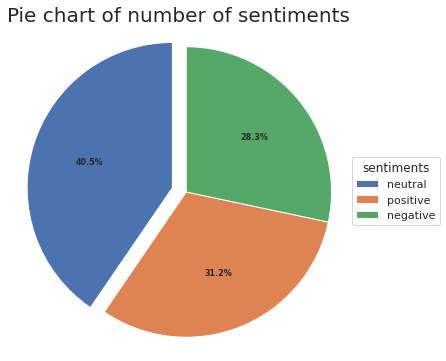

In [ ]:
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py
explode = (0.1, 0, 0)
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(train.sentiment.value_counts(),explode=explode, autopct='%1.1f%%',startangle=90)
ax.legend(wedges, train.sentiment.value_counts().index,
          title="sentiments",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title("Pie chart of number of sentiments",fontsize=20)
plt.show()

**Observation:** Tweets with neutral sentiment are more in number.

### Text

In [ ]:
l = train['text'].str.split().apply(len)
l

0         7
1        10
2         5
3         5
4        14
         ..
27476    16
27477    23
27478    22
27479     6
27480    11
Name: text, Length: 27480, dtype: int64

Text(0.5, 1.0, 'Kernel Distribution of Number Of words in text')

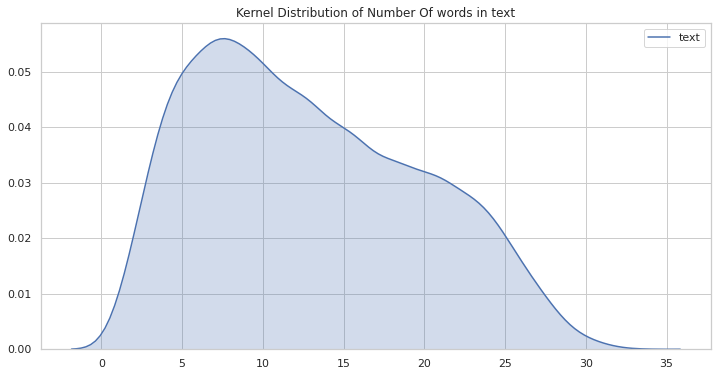

In [ ]:
plt.figure(figsize=(12,6))
sns.kdeplot(train['text'].str.split().apply(len), shade=True, color="b").set_title('Kernel Distribution of Number Of words in text')

**observation:** Most of the texts(tweets) are described in 3 to 25 words.

### selected text

Text(0.5, 1.0, 'Kernel Distribution of Number Of words in selected text')

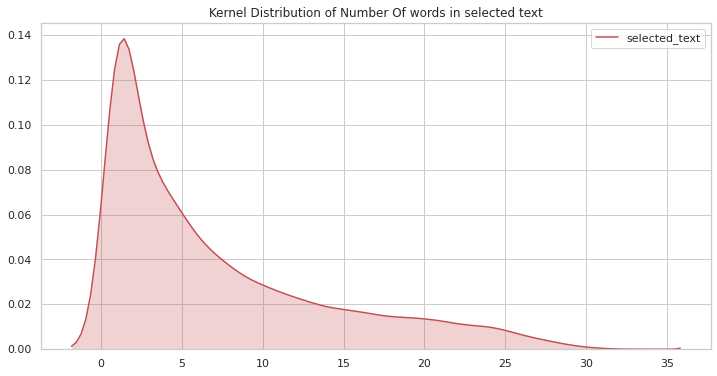

In [ ]:
plt.figure(figsize=(12,6))
sns.kdeplot(train['selected_text'].str.split().apply(len), shade=True, color="r").set_title('Kernel Distribution of Number Of words in selected text')

**observation:** Most of the selected texts are described in 3 to 20 words and the plot is right skewed.

In [ ]:
train.iloc[0:10][['text','selected_text']]

,text,selected_text
0,"I`d have responded, if I were going","I`d have responded, if I were going"
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD
2,my boss is bullying me...,bullying me
3,what interview! leave me alone,leave me alone
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,"
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...
6,2am feedings for the baby are fun when he is a...,fun
7,Soooo high,Soooo high
8,Both of you,Both of you
9,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.


**Observation:** Seems like selected text is a part of the text which is continuous segment of the given text without any jump between the words.Also,there are special characters in selected text, so cleaning of text may not be feasable here.

## MultiVariate Analysis

Let's see details of text and selected text sentiment wise and see whether it is useful to build sentiment wise models or model it as whole.

### Positive

In [ ]:
p = train.groupby('sentiment').get_group('positive')
p.head()

,textID,text,selected_text,sentiment
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive
11,16fab9f95b,I really really like the song Love Story by Ta...,like,positive
21,e48b0b8a23,Playing Ghost Online is really interesting. Th...,interesting.,positive
25,e00c6ef376,"the free fillin` app on my ipod is fun, im add...","the free fillin` app on my ipod is fun, im add...",positive


In [ ]:
p['text_ln'] = p['text'].str.split().apply(len)
p['stext_ln'] = p['selected_text'].str.split().apply(len)
p.head()

,textID,text,selected_text,sentiment,text_ln,stext_ln
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,14,1
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,10,5
11,16fab9f95b,I really really like the song Love Story by Ta...,like,positive,11,1
21,e48b0b8a23,Playing Ghost Online is really interesting. Th...,interesting.,positive,24,1
25,e00c6ef376,"the free fillin` app on my ipod is fun, im add...","the free fillin` app on my ipod is fun, im add...",positive,11,11


Text(0.5, 1.0, 'Kernel Distribution of Number of words in selected text')

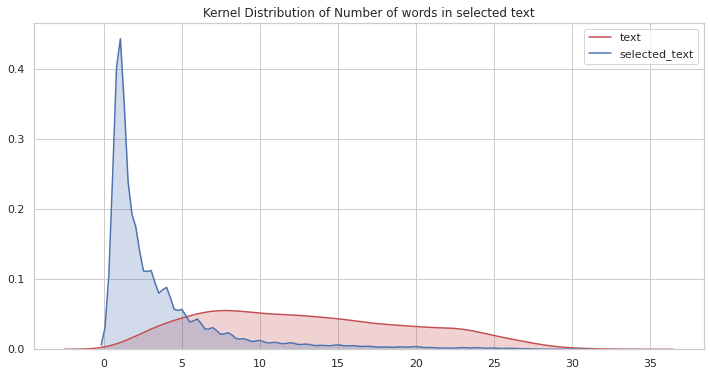

In [ ]:
plt.figure(figsize=(12,6))
sns.kdeplot(p['text'].str.split().apply(len), shade=True, color="r").set_title('Kernel Distribution of Number of words in selected text')
sns.kdeplot(p['selected_text'].str.split().apply(len), shade=True, color="b").set_title('Kernel Distribution of Number of words in selected text')

In [ ]:
#text_count = p['text'].str.split().apply(len).value_counts() #which returns the number of words and how many sentences are with this number of words
#stext_count = p['selected_text'].str.split().apply(len).value_counts()
#ex: 7 3256  --> there are 3256 sentences with 7 words each

**Observation:** seems like there is no much  relation between the number of words in text and select text.so we can't predict directly the number  of words in the selected text.seems like it depends on the sentence a lot and there is need of help of contextual meaning of the sentence and also we can't expect to get the hundred percent accuracy in the predictions because the data itself is not distributed evenly or it's hard to predict the number of words in selected text using text easily.

As length of the selected text doesn't depend on the length of the sentence,let's look at how similar the selected text and text are using jaccard similarity.

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
p['jaccard']  = p.apply(lambda x: jaccard(x.text, x.selected_text), axis=1)

In [ ]:
p.head()

,textID,text,selected_text,sentiment,jaccard
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,0.071429
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,0.500000
11,16fab9f95b,I really really like the song Love Story by Ta...,like,positive,0.100000
21,e48b0b8a23,Playing Ghost Online is really interesting. Th...,interesting.,positive,0.043478
25,e00c6ef376,"the free fillin` app on my ipod is fun, im add...","the free fillin` app on my ipod is fun, im add...",positive,1.000000


Text(0.5, 1.0, 'Kernel Distribution of similarity of positive sentiments')

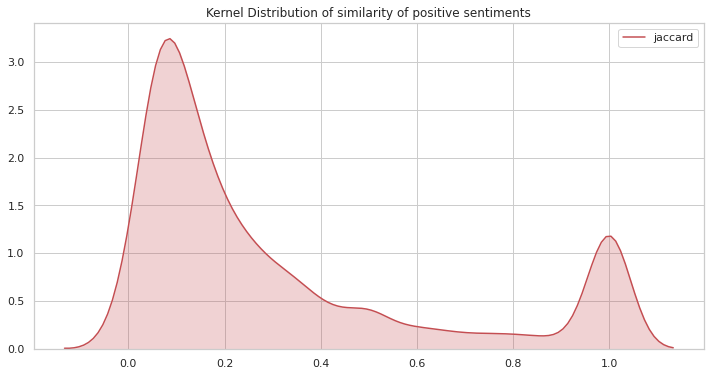

In [ ]:
plt.figure(figsize=(12,6))
sns.kdeplot(p['jaccard'], shade=True, color="r").set_title('Kernel Distribution of similarity of positive sentiments')
#sns.kdeplot(p['selected_text'], shade=True, color="b").set_title('Kernel Distribution of Number of words in selected text')

**Observation:** we can see that there are some points with jaccard similarity 1,let's see those tweets and see if they share any common thing,so that we can predict the selected text as it is from text for some of the tweets like these.

In [ ]:
p[p['jaccard']==1]

,textID,text,selected_text,sentiment,jaccard
25,e00c6ef376,"the free fillin` app on my ipod is fun, im add...","the free fillin` app on my ipod is fun, im add...",positive,1.0
54,d8ba2a99a9,romance zero is funny,romance zero is funny,positive,1.0
68,fa2654e730,Chilliin,Chilliin,positive,1.0
80,bbbc46889b,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,positive,1.0
85,3d2fcd78c8,Happy Star Wars day everyone! and Enjoy the ho...,Happy Star Wars day everyone! and Enjoy the ho...,positive,1.0
...,...,...,...,...,...
27407,04db7e701e,really really wants to go and see Coraline.,really really wants to go and see Coraline.,positive,1.0
27412,878acf5421,i wish you were in my class last year,i wish you were in my class last year,positive,1.0
27417,2151413f96,ish okay my loveee,ish okay my loveee,positive,1.0
27434,0a43c46417,Really good night,Really good night,positive,1.0


**Observation:** We can see that texts with different words,different lengths possess jaccard score as 1,so there are no much commong things here.

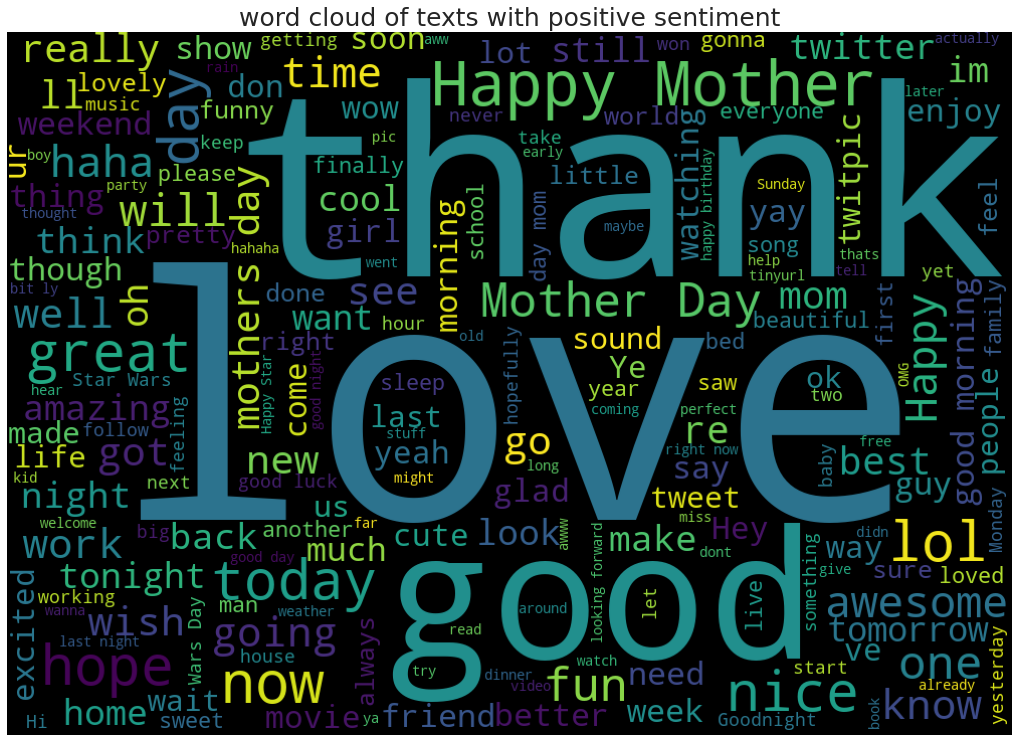

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(max_words=200,width = 1000, height = 700).generate(" ".join(p.text.astype(str)))
plt.figure(figsize = (18, 13))
plt.title('word cloud of texts with positive sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

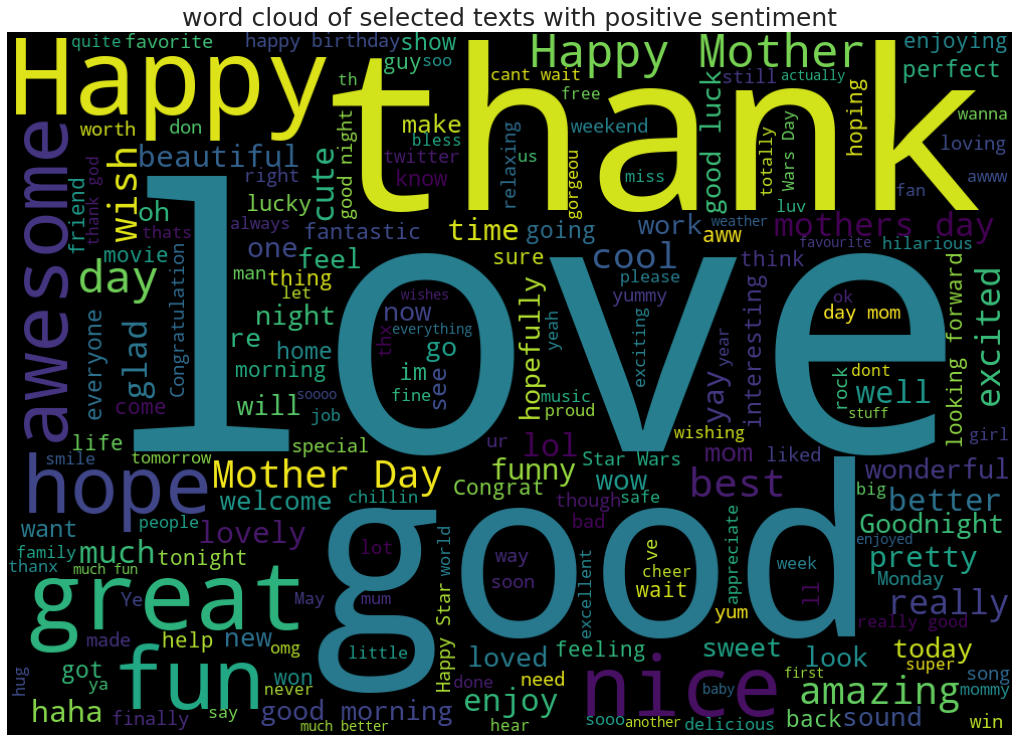

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(max_words=200,width = 1000, height = 700).generate(" ".join(p.selected_text.astype(str)))
plt.figure(figsize = (18, 13))
plt.title('word cloud of selected texts with positive sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

**Observation:** From the word clouds, we can see that most of the words like love,good,thank,happy...etc that are in selected text are the words that gives positive vibe to the sentences,so identifying the words that contribute to the positive sentiment of the tweet can help us in modelling. 

### Negative

In [ ]:
n = train.groupby('sentiment').get_group('negative')
n.head()

,textID,text,selected_text,sentiment
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
12,74a76f6e0a,My Sharpie is running DANGERously low on ink,DANGERously,negative


In [ ]:
n['text_ln'] = n['text'].str.split().apply(len)
n['stext_ln'] = n['selected_text'].str.split().apply(len)
n.head()

,textID,text,selected_text,sentiment,text_ln,stext_ln
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10,2
2,088c60f138,my boss is bullying me...,bullying me,negative,5,2
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5,3
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14,3
12,74a76f6e0a,My Sharpie is running DANGERously low on ink,DANGERously,negative,8,1


Text(0.5, 1.0, 'Kernel Distribution of Number of words in selected text')

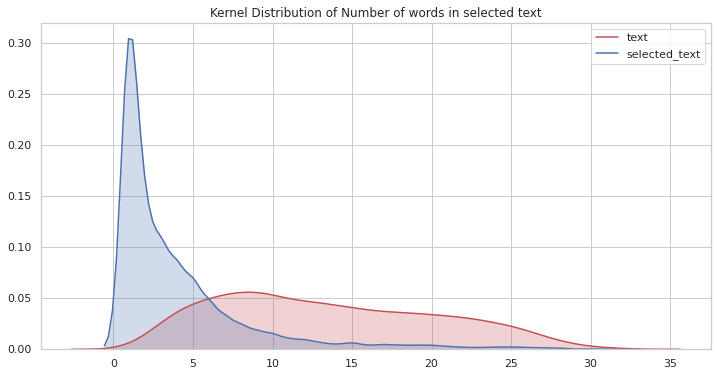

In [ ]:
plt.figure(figsize=(12,6))
sns.kdeplot(n['text'].str.split().apply(len), shade=True, color="r").set_title('Kernel Distribution of Number of words in selected text')
sns.kdeplot(n['selected_text'].str.split().apply(len), shade=True, color="b").set_title('Kernel Distribution of Number of words in selected text')

In [ ]:
#text_count = n['text'].str.split().apply(len).value_counts() #which returns the number of words and how many sentences are with this number of words
#stext_count = n['selected_text'].str.split().apply(len).value_counts()
#ex: 7 3256  --> there are 3256 sentences with 7 words each

**Observation:** seems like there is no much  relation between the number of words in text and select text.Same as positive sentiment, we can't predict directly the number  of words in the selected text.seems like it depends on the sentence a lot and there is need of help of contextual meaning of the sentence and also we can't expect to get the hundred percent accuracy in the predictions because the data itself is not distributed evenly or it's hard to predict the number of words in selected text using text easily.

As length of the selected text doesn't depend on the length of the sentence,let's look at how similar the selected text and text are using jaccard similarity.

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
n['jaccard']  = n.apply(lambda x: jaccard(x.text, x.selected_text), axis=1)

In [ ]:
n.head()

,textID,text,selected_text,sentiment,text_ln,stext_ln,jaccard
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10,2,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,5,2,0.166667
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5,3,0.600000
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14,3,0.214286
12,74a76f6e0a,My Sharpie is running DANGERously low on ink,DANGERously,negative,8,1,0.125000


Text(0.5, 1.0, 'Kernel Distribution of similarity of nrgative sentiments')

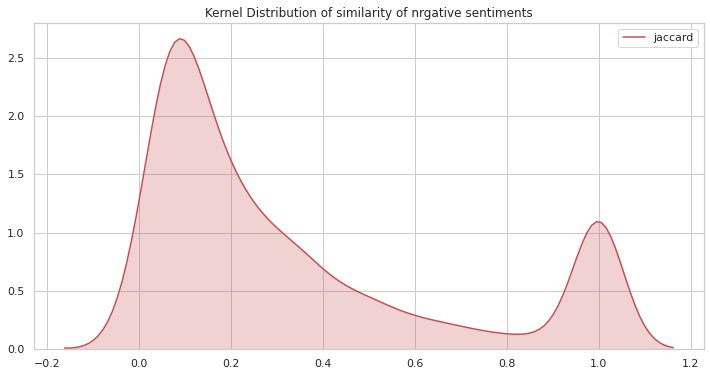

In [ ]:
plt.figure(figsize=(12,6))  
sns.kdeplot(n['jaccard'], shade=True, color="r").set_title('Kernel Distribution of similarity of nrgative sentiments')

**Observation:** we can see that there are some points with jaccard similarity 1,let's see those tweets and see if they share any common thing,so that we can predict the selected text as it is from text for some of the tweets like these.This is also the same case with positive sentiment.

In [ ]:
n[n['jaccard']==1]

,textID,text,selected_text,sentiment,text_ln,stext_ln,jaccard
15,8a939bfb59,"Uh oh, I am sunburned","Uh oh, I am sunburned",negative,5,5,1.0
26,852edc3769,I`m sorry.,I`m sorry.,negative,2,2,1.0
53,11084dac09,it is ****...u have dissappointed me that pas...,it is ****...u have dissappointed me that past...,negative,10,10,1.0
62,2a9765b7f9,I give in to easily,I give in to easily,negative,5,5,1.0
78,0a61cbf4b5,I am sooo tired,I am sooo tired,negative,4,4,1.0
...,...,...,...,...,...,...,...
27348,ea7bc30d23,Killed a pigeon today Thought it was going to...,Killed a pigeon today Thought it was going to...,negative,28,28,1.0
27365,521d5dd501,I bet you received lots of hit from that twee...,I bet you received lots of hit from that tweet...,negative,17,17,1.0
27414,0d46954e4d,WHY DO I EVEN TRY... WHEN DEEP DOWN INSIDE I K...,WHY DO I EVEN TRY... WHEN DEEP DOWN INSIDE I K...,negative,17,17,1.0
27423,bafc9b3f4f,Wow. So I hate Staples right now. Majorly. Tha...,Wow. So I hate Staples right now. Majorly. Tha...,negative,17,17,1.0


**Observation:** We can see that texts with different words,different lengths possess jaccard score as 1,so there are no much commong things here.

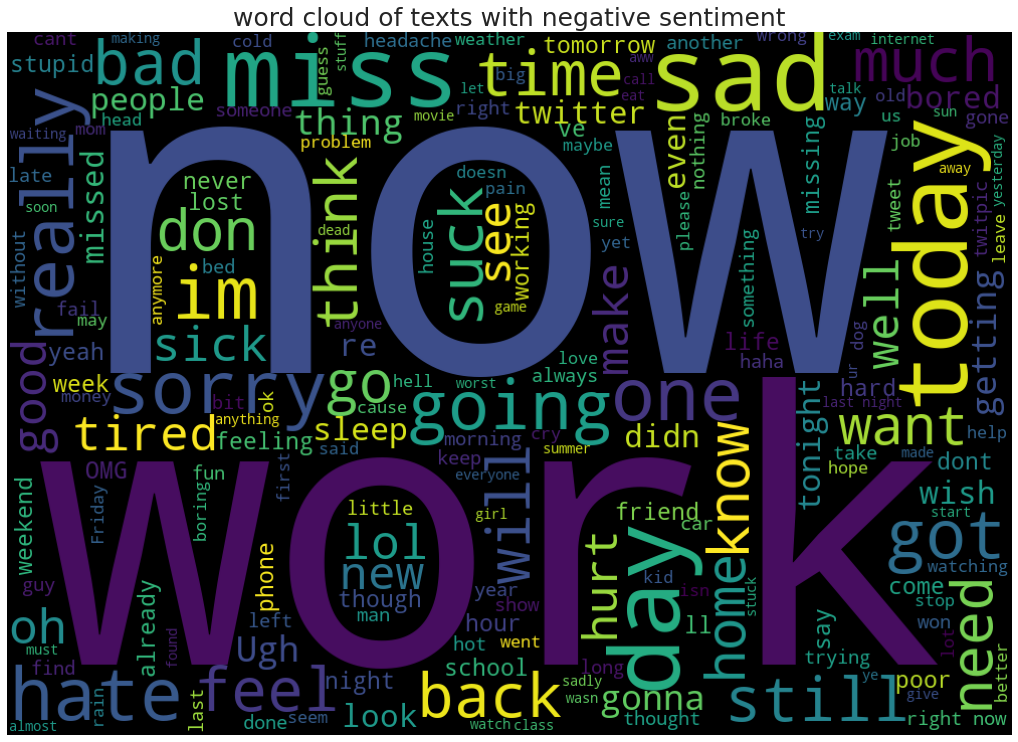

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(max_words=200,width = 1000, height = 700).generate(" ".join(n.text.astype(str)))
plt.figure(figsize = (18, 13))
plt.title('word cloud of texts with negative sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

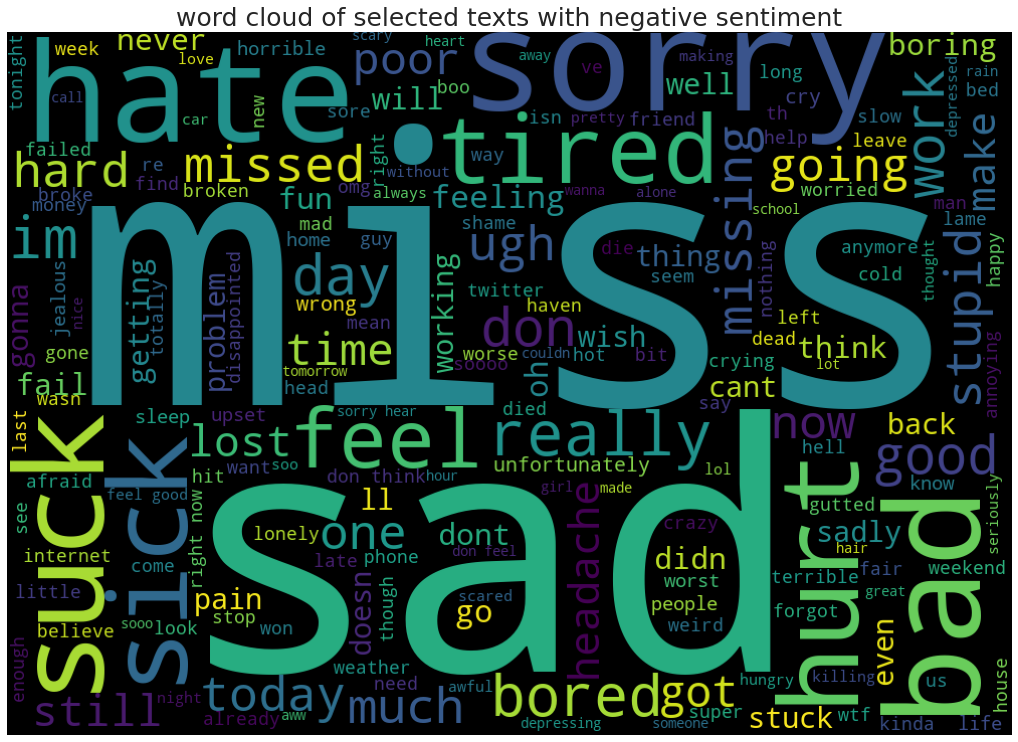

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(max_words=200,width = 1000, height = 700).generate(" ".join(n.selected_text.astype(str)))
plt.figure(figsize = (18, 13))
plt.title('word cloud of selected texts with negative sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

**Observation:** From the word clouds, we can see that most of the words like miss,sad,hurt,bad,hate,sorry...etc that are in selected text are the words that give negative vibe to the sentences,so identifying the words that contribute to the negative sentiment of the tweet is going to play major role in the modelling. 

### Neutral

In [ ]:
nu = train.groupby('sentiment').get_group('neutral')
nu.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
10,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral


In [ ]:
nu['text_ln'] = nu['text'].str.split().apply(len)
nu['stext_ln'] = nu['selected_text'].str.split().apply(len)
nu.head()

,textID,text,selected_text,sentiment,text_ln,stext_ln
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,7
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,12,12
7,50e14c0bb8,Soooo high,Soooo high,neutral,2,2
8,e050245fbd,Both of you,Both of you,neutral,3,3
10,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral,23,23


Seems like for neutral tweets, selected text is the whole text of the given the given tweet,let's confirm it with distribution plot.

Text(0.5, 1.0, 'Kernel Distribution of Number of words in selected text')

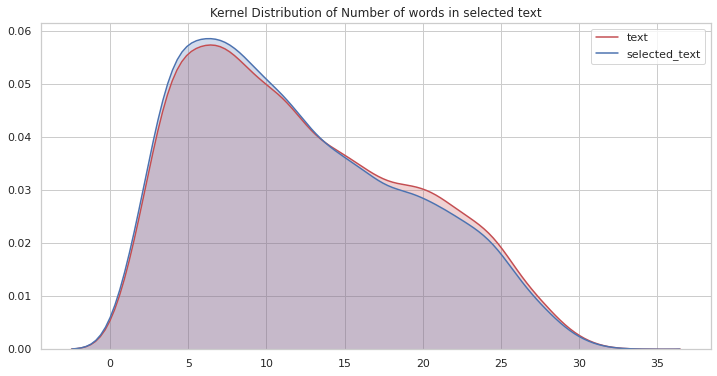

In [ ]:
plt.figure(figsize=(12,6))
sns.kdeplot(nu['text'].str.split().apply(len), shade=True, color="r").set_title('Kernel Distribution of Number of words in selected text')
sns.kdeplot(nu['selected_text'].str.split().apply(len), shade=True, color="b").set_title('Kernel Distribution of Number of words in selected text')

In [ ]:
#text_count = nu['text'].str.split().apply(len).value_counts() #which returns the number of words and how many sentences are with this number of words
#stext_count = nu['selected_text'].str.split().apply(len).value_counts()
#ex: 7 3256  --> there are 3256 sentences with 7 words each

**Observation:** As the distributions are overlapping,it looks like most of the selected texts of neutral tweets are same as their respective texts.Let's look at the jaccard similarity,which will confirm us about our assumption.

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
nu['jaccard']  = nu.apply(lambda x: jaccard(x.text, x.selected_text), axis=1)

In [ ]:
nu.head()

,textID,text,selected_text,sentiment,text_ln,stext_ln,jaccard
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,7,1.0
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,12,12,1.0
7,50e14c0bb8,Soooo high,Soooo high,neutral,2,2,1.0
8,e050245fbd,Both of you,Both of you,neutral,3,3,1.0
10,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral,23,23,1.0


Text(0.5, 1.0, 'Kernel Distribution of similarity of neutral sentiments')

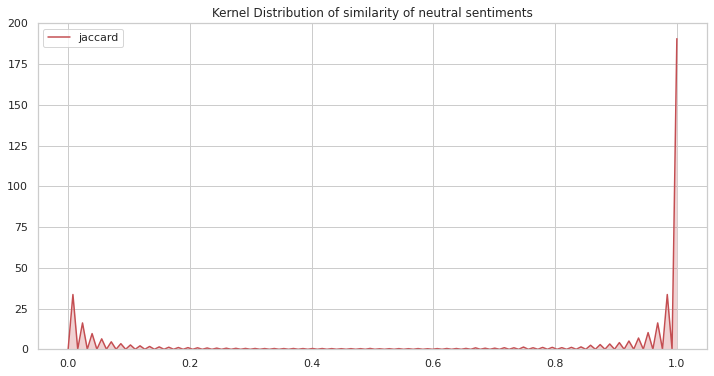

In [ ]:
plt.figure(figsize=(12,6))
sns.kdeplot(nu['jaccard'], shade=True, color="r").set_title('Kernel Distribution of similarity of neutral sentiments')
#sns.kdeplot(p['selected_text'], shade=True, color="b").set_title('Kernel Distribution of Number of words in selected text')

**Observation:** we can see that most of the tweets are having jaccard similarity greater than 0.8

In [ ]:
one = nu[nu.jaccard==1].shape[0]
print('Jaccard similarity is 1 for {} datapoints, i.e. {:.2f} % of neutral tweets.' .format(one, 100.0*one/nu.shape[0]))

Jaccard similarity is 1 for 10012 datapoints, i.e. 90.06 % of neutral tweets.


In [4]:
t = nu[nu.jaccard>0.8].shape[0]
print('Jaccard similarity is greater than 0.8 for {} datapoints, i.e. {:.2f} % of neutral tweets.' .format(t, 100.0*t/nu.shape[0]))

Jaccard similarity is greater than 0.8 for {} datapoints, i.e. 95.90 % of neutral tweets.


**Observation:** For almost 90% of the neutral tweets selected text and text are same and for 96% of the tweets, selected text is 80% of the original text.
Let's observe the tweets where jaccard similarity is less than 0.8

In [ ]:
notone = nu[nu['jaccard']!=1] #get the rows where jaccard score is not equal to one and is greater than 0.8
notone[notone['jaccard']>0.8]

,textID,text,selected_text,sentiment,text_ln,stext_ln,jaccard
86,0c0563423e,Miles from you I`m in Essex so give me plen...,Miles from you I`m in Essex so give me plent...,neutral,27,27,0.920000
199,7a718b23ef,_Sanderson What`s with Twatter lately? Either...,What`s with Twatter lately? Either I can`t ge...,neutral,16,15,0.937500
220,e70d294d95,@_Ra_Ra_ your not alone...i need coffee too.,your not alone...i need coffee too.,neutral,7,6,0.857143
289,2dd0cddb70,I want it BACK NOW!: http://bit.ly/PP1WZ,I want it BACK NOW!:,neutral,6,5,0.833333
316,d2af698d65,Home empty handed. No comics found today. I ...,Home empty handed. No comics found today. I ...,neutral,17,17,0.888889
...,...,...,...,...,...,...,...
27230,ce277c9380,"gonna be in bed soon as Friday`s over soon, ...","gonna be in bed soon as Friday`s over soon, ...",neutral,14,14,0.928571
27278,c0da406e23,samee well i aint a man i am a girl obv nd i ...,samee well i aint a man i am a girl obv nd i a...,neutral,30,29,0.956522
27315,cad70bf44a,Poor you If I was with you right now; I wou...,Poor you If I was with you right now; I woul...,neutral,17,16,0.928571
27349,f60f20ed09,"yea but that`s an old pic, she looks a lot d...","yea but that`s an old pic, she looks a lot di...",neutral,23,23,0.909091


**Observation:** We can see that texts with different words,different lengths possess different jaccard scores,so there are no much common things here.

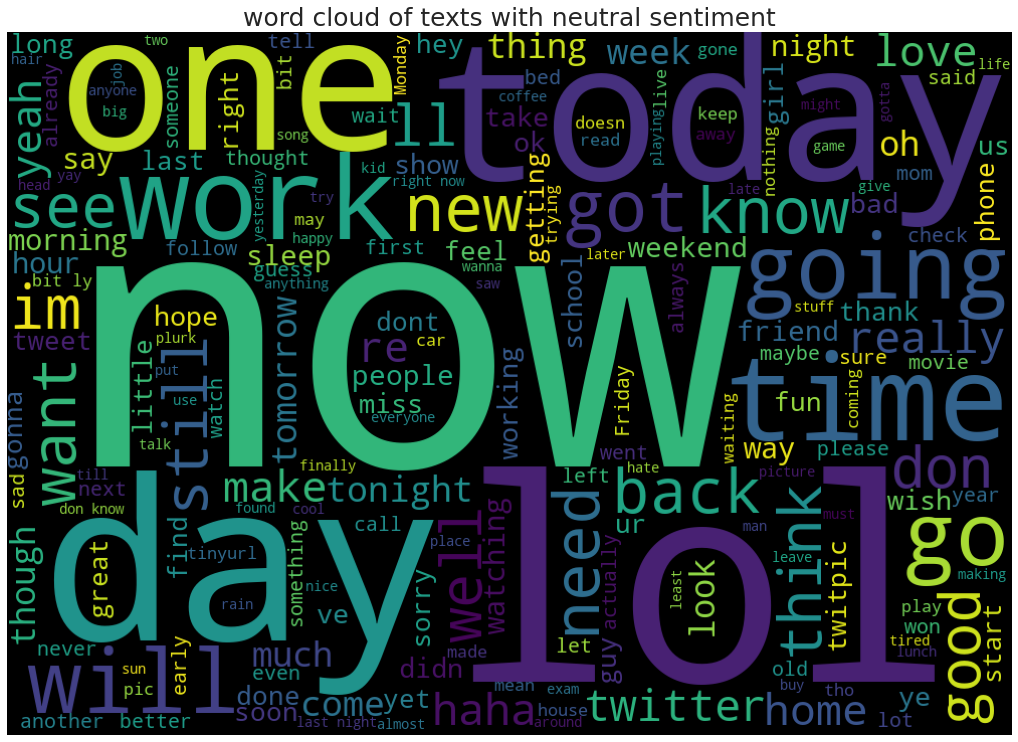

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(max_words=200,width = 1000, height = 700).generate(" ".join(nu.text.astype(str)))
plt.figure(figsize = (18, 13))
plt.title('word cloud of texts with neutral sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

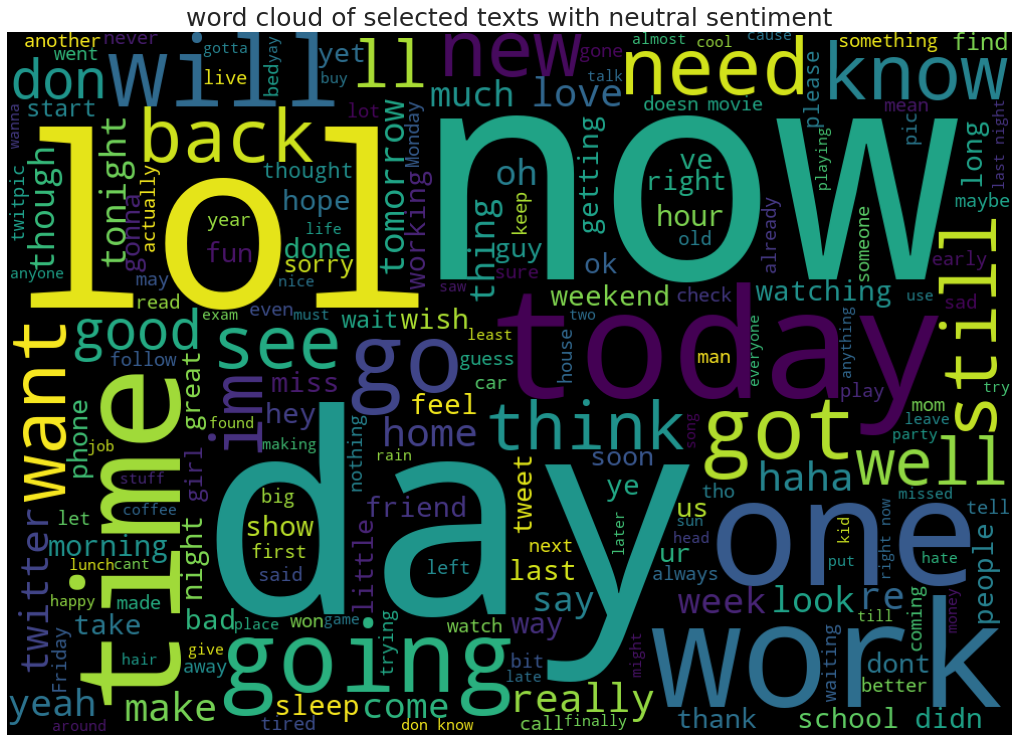

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(max_words=200,width = 1000, height = 700).generate(" ".join(nu.selected_text.astype(str)))
plt.figure(figsize = (18, 13))
plt.title('word cloud of selected texts with neutral sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

**Observation:** From the word clouds, we can see that most of the words like now,day,time,lol...etc that are in selected text are the words that gave neutral which is neither positive nor negative vibe to the sentences,so identifying these words may help us getting neutral sentiment words as selected text. 

##Key observations from Exploratory Data Analysis:


*   Tweets with neutral sentiment have selected text almost same as text.We will use this in modelling,if needed.
*   Modelling sentiment wise may not be make much difference here,as selected text is distribution is not same as text in positive and negative cases and the extracted selected text has the words which differentiates the selected text based on the given sentiment,so,taking this problem as a single model can hadle the problem.


*   From word cloud,identifying the words in the sentence which contribute as per the given sentiment,place a key role in the predictions of selected texts.

*   Selected text is copy paste of a part of the text,so cleaning the data may not be feasable here,we will see whether cleaning data improves model performance during modelling.

*   We can observe that there are some words which are wrongly spelt like girltz,soooo,youuuu... and even special characters are repeated multiple times, even selected text has these words in some cases, so we have to take the text as it is without much disturbing these words.

*   As there is lot of noise and there isn't much equality in distribution of length of selected texts, we can't expect any machine learning model to get 100% accuracy and the encodings and models which takes care of contextual meaning of sentences will give us better results.








## Approaches to Modelling


*   we can model this problem as multi label classification problem, by naively predicting the selected text using one hot representation of the output words.
We can start with classical models and try RNN's using LSTM with different encodings of text data.

*   As identifying the sentiment  words plays a major role, we will take n grams from text and check the sentiment scores and check if picking up maximum sentiment score words helps us in extracting the texts.

*   As we have to pick some of the words from the text,we can try Named Entity Recognition systems to extract some of the words and check these helps in predictions.

*   As there is unenven distribution of number of words in selected texts,contextual meaning may play major role here, so trying out the state of the art models like BERT,RoBERTa...which takes care of the contextual meanings can help us.
*   As input and output both are texts and output is a part of text which is continuouos without any jump betweeen the words,we can model this as Question Answering model using above mentioned techniques.

